# 02 - Análisis de Umbrales del Acuerdo de París
## Pregunta: ¿Cuándo cruzamos los umbrales críticos de calentamiento?

### Objetivos:
- Identificar cuándo se cruzó el umbral de +1.0°C
- Proyectar cuándo se cruzará el umbral de +1.5°C
- Proyectar cuándo se cruzará el umbral de +2.0°C
- Visualizar la tendencia histórica vs umbrales de París

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Carga de Datos Procesados	

In [135]:
# Cargar datos mensuales y anuales
df_monthly = pd.read_csv('../data/processed/monthly_anomalies.csv')
df_annual = pd.read_csv('../data/processed/annual_anomalies.csv')
df_complete = pd.read_csv('../data/processed/complete_clean_data.csv')

# Convertir fecha a datetime
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_complete['Date'] = pd.to_datetime(df_complete['Date'])

print(f"📊 Datos cargados:")
print(f"   - Registros mensuales: {len(df_monthly):,}")
print(f"   - Registros anuales: {len(df_annual)}")
print(f"   - Período: {df_monthly['Year'].min()} - {df_monthly['Year'].max()}")

df_monthly.head()

📊 Datos cargados:
   - Registros mensuales: 2,100
   - Registros anuales: 175
   - Período: 1850 - 2024


,Date,Year,Month,Decade,Season,Monthly_Anomaly,Monthly_Unc,Is_Positive_Anomaly,Is_Cold_Month,Is_Hot_Month,Above_1C,Above_1_5C,Above_2C
0,1850-01-01,1850,1,1850,Winter,-0.753,0.365,False,True,False,False,False,False
1,1850-02-01,1850,2,1850,Winter,-0.202,0.416,False,False,False,False,False,False
2,1850-03-01,1850,3,1850,Spring,-0.367,0.373,False,False,False,False,False,False
3,1850-04-01,1850,4,1850,Spring,-0.596,0.324,False,True,False,False,False,False
4,1850-05-01,1850,5,1850,Spring,-0.619,0.267,False,True,False,False,False,False


## 2. Identificación de Cruces de Umbrales (Análisis Mensual)

In [136]:
# Función para encontrar el primer cruce sostenido de un umbral
def find_threshold_crossing(df, threshold, window=12):
    """
    Encuentra el primer cruce sostenido de un umbral.
    Un cruce es considerado 'sostenido' si el promedio móvil de 12 meses 
    se mantiene por encima del umbral.
    """
    df_temp = df.copy()
    df_temp['Rolling_Avg'] = df_temp['Monthly_Anomaly'].rolling(window=window, center=False).mean()
    
    # Encontrar primer punto donde el promedio móvil supera el umbral
    above_threshold = df_temp[df_temp['Rolling_Avg'] >= threshold]
    
    if len(above_threshold) > 0:
        first_cross = above_threshold.iloc[0]
        return first_cross['Date'], first_cross['Year'], first_cross['Month']
    else:
        return None, None, None

# Identificar cruces de umbrales
thresholds = [1.0, 1.5, 2.0]
crossings = {}

print("\n" + "=" * 70)
print("IDENTIFICACIÓN DE CRUCES DE UMBRALES (Promedio móvil 12 meses)")
print("=" * 70)

for threshold in thresholds:
    date, year, month = find_threshold_crossing(df_monthly, threshold)
    crossings[threshold] = {'year': year, 'month': month}
    
    if year is not None:
        print(f"\n🌡️  Umbral de +{threshold}°C:")
        print(f"   Primer cruce sostenido en {year}")
        print(f"   Fecha exacta: {month:02d}-{year}")
    else:
        print(f"\n🌡️  Umbral de +{threshold}°C:")
        print(f"   ⚠️  NO ALCANZADO AÚN")

# Guardar resultados
crossings_df = pd.DataFrame(crossings).T
crossings_df.index.name = 'Threshold'
crossings_df.reset_index(inplace=True)
crossings_df


IDENTIFICACIÓN DE CRUCES DE UMBRALES (Promedio móvil 12 meses)

🌡️  Umbral de +1.0°C:
   Primer cruce sostenido en 2016
   Fecha exacta: 03-2016

🌡️  Umbral de +1.5°C:
   ⚠️  NO ALCANZADO AÚN

🌡️  Umbral de +2.0°C:
   ⚠️  NO ALCANZADO AÚN


,Threshold,year,month
0,1.0,2016,3
1,1.5,None,None
2,2.0,None,None


## 3. Análisis con Promedios Anuales

In [137]:
# Análisis basado en promedios anuales
print("\n" + "=" * 70)
print("ANÁLISIS CON PROMEDIOS ANUALES")
print("=" * 70)

# Primer año que supera cada umbral (promedio anual)
for threshold in thresholds:
    years_above = df_annual[df_annual['Monthly_Avg_Anomaly'] >= threshold]
    
    if len(years_above) > 0:
        first_year = years_above.iloc[0]
        print(f"\n🌡️  Umbral de +{threshold}°C (promedio anual):")
        print(f"   Primer año completo: {first_year['Year']:.0f}")
        print(f"   Anomalía ese año: {first_year['Monthly_Avg_Anomaly']:.3f}°C")
        print(f"   Años desde entonces: {len(df_annual[df_annual['Year'] >= first_year['Year']])} años")
    else:
        print(f"\n🌡️  Umbral de +{threshold}°C:")
        print(f"   ⚠️  Ningún año completo ha superado este umbral aún")
        
        # Mostrar año más cercano
        closest_year = df_annual.loc[df_annual['Monthly_Avg_Anomaly'].idxmax()]
        print(f"   📊 Año más cercano: {closest_year['Year']:.0f} ({closest_year['Monthly_Avg_Anomaly']:.3f}°C)")
        print(f"   📊 Diferencia: {threshold - closest_year['Monthly_Avg_Anomaly']:.3f}°C")


ANÁLISIS CON PROMEDIOS ANUALES

🌡️  Umbral de +1.0°C (promedio anual):
   Primer año completo: 2016
   Anomalía ese año: 1.058°C
   Años desde entonces: 9 años

🌡️  Umbral de +1.5°C:
   ⚠️  Ningún año completo ha superado este umbral aún
   📊 Año más cercano: 2024 (1.311°C)
   📊 Diferencia: 0.189°C

🌡️  Umbral de +2.0°C:
   ⚠️  Ningún año completo ha superado este umbral aún
   📊 Año más cercano: 2024 (1.311°C)
   📊 Diferencia: 0.689°C


## 4. Tendencia Histórica y Velocidad de Calentamiento

In [138]:
# Calcular tendencias en diferentes períodos
periods = [
    (1850, 1920, 'Periodo Inicial'),
    (1920, 1980, 'Periodo Intermedio'),
    (1980, 2024, 'Periodo Moderno'),
    (2000, 2024, 'Siglo XXI'),
    (2010, 2024, 'Última Década')
]

print("\n" + "=" * 70)
print("TASAS DE CALENTAMIENTO POR PERÍODO")
print("=" * 70)

trends_data = []

for start_year, end_year, period_name in periods:
    period_data = df_annual[(df_annual['Year'] >= start_year) & (df_annual['Year'] <= end_year)].copy()
    
    if len(period_data) > 1:
        X = period_data['Year'].values.reshape(-1, 1)
        y = period_data['Monthly_Avg_Anomaly'].values
        
        # Regresión lineal
        model = LinearRegression()
        model.fit(X, y)
        
        # Tasa de calentamiento por década
        rate_per_decade = model.coef_[0] * 10
        
        trends_data.append({
            'Periodo': period_name,
            'Años': f"{start_year}-{end_year}",
            'Tasa_Decada': rate_per_decade,
        })
        
        print(f"\n📈 {period_name} ({start_year}-{end_year}):")
        print(f"   Tasa de calentamiento: {rate_per_decade:+.4f}°C por década")
        print(f"   Duración: {end_year - start_year} años")
        print(f"   Cambio total estimado: {model.coef_[0] * (end_year - start_year):+.3f}°C")

trends_df = pd.DataFrame(trends_data)

# Visualizar aceleración del calentamiento
print(f"\n🚀 ACELERACIÓN DEL CALENTAMIENTO:")
print(f"   Relación Moderno/Intermedio: {abs(trends_df.iloc[2]['Tasa_Decada']) / abs(trends_df.iloc[1]['Tasa_Decada']):.1f}x más rápido")
print(f"   Relación Siglo XXI/Intermedio: {abs(trends_df.iloc[3]['Tasa_Decada']) / abs(trends_df.iloc[1]['Tasa_Decada']):.1f}x más rápido")

trends_df


TASAS DE CALENTAMIENTO POR PERÍODO

📈 Periodo Inicial (1850-1920):
   Tasa de calentamiento: -0.0078°C por década
   Duración: 70 años
   Cambio total estimado: -0.054°C

📈 Periodo Intermedio (1920-1980):
   Tasa de calentamiento: +0.0465°C por década
   Duración: 60 años
   Cambio total estimado: +0.279°C

📈 Periodo Moderno (1980-2024):
   Tasa de calentamiento: +0.2078°C por década
   Duración: 44 años
   Cambio total estimado: +0.914°C

📈 Siglo XXI (2000-2024):
   Tasa de calentamiento: +0.2571°C por década
   Duración: 24 años
   Cambio total estimado: +0.617°C

📈 Última Década (2010-2024):
   Tasa de calentamiento: +0.3552°C por década
   Duración: 14 años
   Cambio total estimado: +0.497°C

🚀 ACELERACIÓN DEL CALENTAMIENTO:
   Relación Moderno/Intermedio: 4.5x más rápido
   Relación Siglo XXI/Intermedio: 5.5x más rápido


,Periodo,Años,Tasa_Decada
0,Periodo Inicial,1850-1920,-0.007750
1,Periodo Intermedio,1920-1980,0.046503
2,Periodo Moderno,1980-2024,0.207832
3,Siglo XXI,2000-2024,0.257096
4,Última Década,2010-2024,0.355173


## 5. Proyecciones hacia +1.5ºC

In [139]:
# Proyecciones usando diferentes métodos
print("\n" + "=" * 70)
print("PROYECCIONES HACIA EL UMBRAL DE +1.5°C")
print("=" * 70)

# Usar datos desde 1980 (periodo moderno) para proyección
recent_data = df_annual[df_annual['Year'] >= 1980].copy()
X_recent = recent_data['Year'].values.reshape(-1, 1)
y_recent = recent_data['Monthly_Avg_Anomaly'].values

# 1. Proyección Lineal
linear_model = LinearRegression()
linear_model.fit(X_recent, y_recent)

# Calcular cuándo se alcanzará 1.5°C
year_1_5C_linear = (1.5 - linear_model.intercept_) / linear_model.coef_[0]

print(f"\n📊 PROYECCIÓN LINEAL (basada en 1980-2024):")
print(f"   Tasa actual: {linear_model.coef_[0] * 10:+.4f}°C por década")
print(f"   Año estimado para +1.5°C: {int(year_1_5C_linear)}")
print(f"   Tiempo restante: {int(year_1_5C_linear) - 2024} años")

# 2. Proyección Polinómica (grado 2)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_recent)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_recent)

# Encontrar año para 1.5°C con modelo polinómico
years_future = np.arange(2024, 2100, 1).reshape(-1, 1)
years_future_poly = poly_features.transform(years_future)
predictions_poly = poly_model.predict(years_future_poly)

idx_1_5C_poly = np.argmax(predictions_poly >= 1.5)
year_1_5C_poly = 2024 + idx_1_5C_poly if predictions_poly[idx_1_5C_poly] >= 1.5 else None

if year_1_5C_poly:
    print(f"\n📊 PROYECCIÓN POLINÓMICA (aceleración considerada):")
    print(f"   Año estimado para +1.5°C: {year_1_5C_poly}")
    print(f"   Tiempo restante: {year_1_5C_poly - 2024} años")

# 3. Proyección usando solo última década (tendencia más reciente)
last_decade = df_annual[df_annual['Year'] >= 2014].copy()
X_decade = last_decade['Year'].values.reshape(-1, 1)
y_decade = last_decade['Monthly_Avg_Anomaly'].values

decade_model = LinearRegression()
decade_model.fit(X_decade, y_decade)

year_1_5C_decade = (1.5 - decade_model.intercept_) / decade_model.coef_[0]

print(f"\n📊 PROYECCIÓN ÚLTIMA DÉCADA (2014-2024):")
print(f"   Tasa reciente: {decade_model.coef_[0] * 10:+.4f}°C por década")
print(f"   Año estimado para +1.5°C: {int(year_1_5C_decade)}")
print(f"   Tiempo restante: {int(year_1_5C_decade) - 2024} años")

# Resumen de proyecciones
print(f"\n" + "=" * 70)
print(f"📌 RESUMEN DE PROYECCIONES PARA +1.5°C:")
print(f"   • Escenario conservador (lineal 1980-2024): ~{int(year_1_5C_linear)}")
if year_1_5C_poly:
    print(f"   • Escenario con aceleración (polinomial): ~{year_1_5C_poly}")
print(f"   • Escenario tendencia actual (2014-2024): ~{int(year_1_5C_decade)}")
print(f"\n   ⚠️  Rango estimado: {min(int(year_1_5C_linear), int(year_1_5C_decade))}-{max(int(year_1_5C_linear), int(year_1_5C_decade))}")
print("=" * 70)


PROYECCIONES HACIA EL UMBRAL DE +1.5°C

📊 PROYECCIÓN LINEAL (basada en 1980-2024):
   Tasa actual: +0.2078°C por década
   Año estimado para +1.5°C: 2045
   Tiempo restante: 21 años

📊 PROYECCIÓN POLINÓMICA (aceleración considerada):
   Año estimado para +1.5°C: 2034
   Tiempo restante: 10 años

📊 PROYECCIÓN ÚLTIMA DÉCADA (2014-2024):
   Tasa reciente: +0.3221°C por década
   Año estimado para +1.5°C: 2034
   Tiempo restante: 10 años

📌 RESUMEN DE PROYECCIONES PARA +1.5°C:
   • Escenario conservador (lineal 1980-2024): ~2045
   • Escenario con aceleración (polinomial): ~2034
   • Escenario tendencia actual (2014-2024): ~2034

   ⚠️  Rango estimado: 2034-2045


## 6. Proyecciones hacia +2.0°C

In [140]:
# Proyecciones usando diferentes métodos
print("\n" + "=" * 70)
print("PROYECCIONES HACIA EL UMBRAL DE +2.0°C")
print("=" * 70)

# Usar datos desde 1980 (periodo moderno) para proyección
recent_data = df_annual[df_annual['Year'] >= 1980].copy()
X_recent = recent_data['Year'].values.reshape(-1, 1)
y_recent = recent_data['Monthly_Avg_Anomaly'].values

# 1. Proyección Lineal
linear_model = LinearRegression()
linear_model.fit(X_recent, y_recent)

# Calcular cuándo se alcanzará 2.0°C
year_2C_linear = (2.0 - linear_model.intercept_) / linear_model.coef_[0]

print(f"\n📊 PROYECCIÓN LINEAL (basada en 1980-2024):")
print(f"   Tasa actual: {linear_model.coef_[0] * 10:+.4f}°C por década")
print(f"   Año estimado para +2.0°C: {int(year_2C_linear)}")
print(f"   Tiempo restante: {int(year_2C_linear) - 2024} años")

# 2. Proyección Polinómica (grado 2)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_recent)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_recent)

# Encontrar año para 2°C con modelo polinómico
years_future = np.arange(2024, 2100, 1).reshape(-1, 1)
years_future_poly = poly_features.transform(years_future)
predictions_poly = poly_model.predict(years_future_poly)

idx_2C_poly = np.argmax(predictions_poly >= 2.0)
year_2C_poly = 2024 + idx_2C_poly if predictions_poly[idx_2C_poly] >= 2.0 else None

if year_2C_poly:
    print(f"\n📊 PROYECCIÓN POLINÓMICA (aceleración considerada):")
    print(f"   Año estimado para +2.0°C: {year_2C_poly}")
    print(f"   Tiempo restante: {year_2C_poly - 2024} años")

# 3. Proyección usando solo última década (tendencia más reciente)
last_decade = df_annual[df_annual['Year'] >= 2014].copy()
X_decade = last_decade['Year'].values.reshape(-1, 1)
y_decade = last_decade['Monthly_Avg_Anomaly'].values

decade_model = LinearRegression()
decade_model.fit(X_decade, y_decade)

year_2C_decade = (2.0 - decade_model.intercept_) / decade_model.coef_[0]

print(f"\n📊 PROYECCIÓN ÚLTIMA DÉCADA (2014-2024):")
print(f"   Tasa reciente: {decade_model.coef_[0] * 10:+.4f}°C por década")
print(f"   Año estimado para +2.0°C: {int(year_2C_decade)}")
print(f"   Tiempo restante: {int(year_2C_decade) - 2024} años")

# Resumen de proyecciones
print(f"\n" + "=" * 70)
print(f"📌 RESUMEN DE PROYECCIONES PARA +2.0°C:")
print(f"   • Escenario conservador (lineal 1980-2024): ~{int(year_2C_linear)}")
if year_2C_poly:
    print(f"   • Escenario con aceleración (polinomial): ~{year_2C_poly}")
print(f"   • Escenario tendencia actual (2014-2024): ~{int(year_2C_decade)}")
print(f"\n   ⚠️  Rango estimado: {min(int(year_2C_linear), int(year_2C_decade))}-{max(int(year_2C_linear), int(year_2C_decade))}")
print("=" * 70)


PROYECCIONES HACIA EL UMBRAL DE +2.0°C

📊 PROYECCIÓN LINEAL (basada en 1980-2024):
   Tasa actual: +0.2078°C por década
   Año estimado para +2.0°C: 2069
   Tiempo restante: 45 años

📊 PROYECCIÓN POLINÓMICA (aceleración considerada):
   Año estimado para +2.0°C: 2046
   Tiempo restante: 22 años

📊 PROYECCIÓN ÚLTIMA DÉCADA (2014-2024):
   Tasa reciente: +0.3221°C por década
   Año estimado para +2.0°C: 2049
   Tiempo restante: 25 años

📌 RESUMEN DE PROYECCIONES PARA +2.0°C:
   • Escenario conservador (lineal 1980-2024): ~2069
   • Escenario con aceleración (polinomial): ~2046
   • Escenario tendencia actual (2014-2024): ~2049

   ⚠️  Rango estimado: 2049-2069


## 7. Visualizaciones Principales

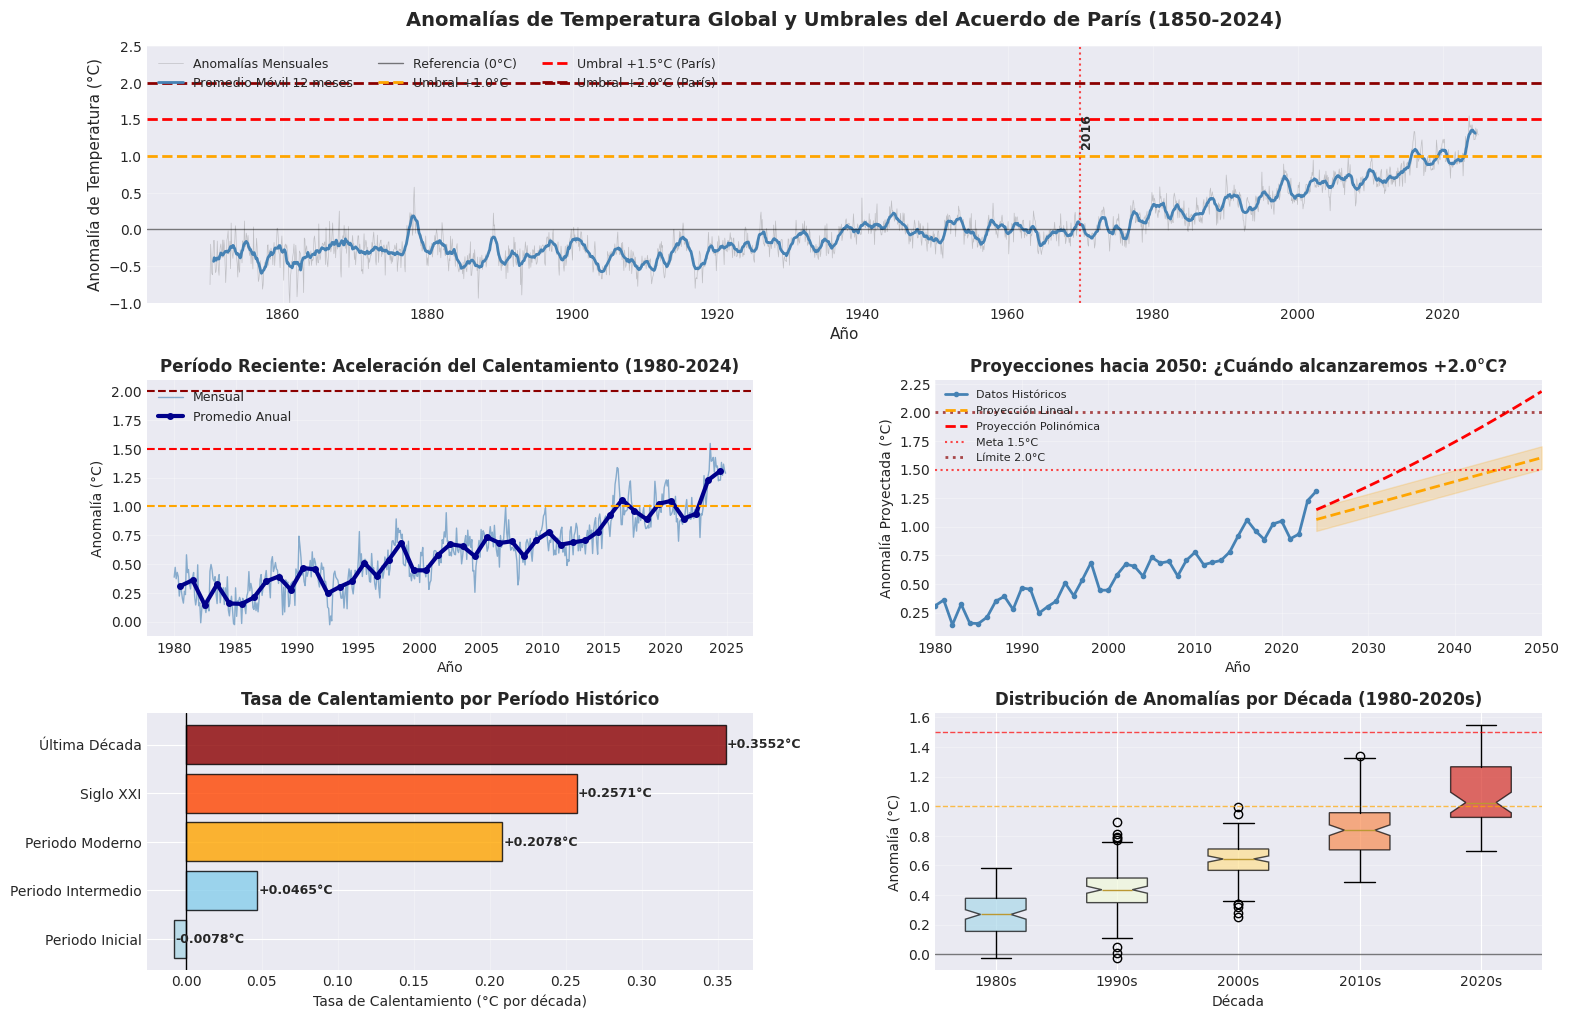


✅ Visualización guardada en: figures/02_paris_thresholds_analysis.png


In [141]:
import os
os.makedirs('../figures', exist_ok=True)

# Crear figura principal con múltiples paneles
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# ============================================================================
# Panel 1: Serie temporal completa con umbrales
# ============================================================================
ax1 = fig.add_subplot(gs[0, :])

# Datos mensuales
ax1.plot(df_monthly['Date'], df_monthly['Monthly_Anomaly'], 
         linewidth=0.5, alpha=0.4, color='gray', label='Anomalías Mensuales')

# Promedio móvil de 12 meses
rolling_12m = df_monthly['Monthly_Anomaly'].rolling(window=12, center=True).mean()
ax1.plot(df_monthly['Date'], rolling_12m, 
         linewidth=2, color='steelblue', label='Promedio Móvil 12 meses')

# Umbrales
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Referencia (0°C)')
ax1.axhline(y=1.0, color='orange', linestyle='--', linewidth=2, label='Umbral +1.0°C')
ax1.axhline(y=1.5, color='red', linestyle='--', linewidth=2, label='Umbral +1.5°C (París)')
ax1.axhline(y=2.0, color='darkred', linestyle='--', linewidth=2, label='Umbral +2.0°C (París)')

# Marcar cruces de umbrales
for threshold in [1.0, 1.5]:
    if crossings[threshold]['year'] is not None:
        ax1.axvline(x=pd.to_datetime(crossings[threshold]['year']), 
                   color='red', linestyle=':', linewidth=1.5, alpha=0.7)
        ax1.text(pd.to_datetime(crossings[threshold]['year']), threshold + 0.1,
                f"{crossings[threshold]['year']}", 
                rotation=90, verticalalignment='bottom', fontsize=9, fontweight='bold')

ax1.set_title('Anomalías de Temperatura Global y Umbrales del Acuerdo de París (1850-2024)', 
             fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Año', fontsize=11)
ax1.set_ylabel('Anomalía de Temperatura (°C)', fontsize=11)
ax1.legend(loc='upper left', fontsize=9, ncol=3)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-1, 2.5])

# ============================================================================
# Panel 2: Zoom en período reciente (1980-2024)
# ============================================================================
ax2 = fig.add_subplot(gs[1, 0])

recent_monthly = df_monthly[df_monthly['Year'] >= 1980]
ax2.plot(recent_monthly['Date'], recent_monthly['Monthly_Anomaly'], 
         linewidth=1, alpha=0.6, color='steelblue', label='Mensual')

# Promedio anual
recent_annual = df_annual[df_annual['Year'] >= 1980]
ax2.plot(pd.to_datetime(recent_annual['Year'].astype(str) + '-07-01'), 
         recent_annual['Monthly_Avg_Anomaly'],
         linewidth=3, color='darkblue', marker='o', markersize=4, label='Promedio Anual')

ax2.axhline(y=1.0, color='orange', linestyle='--', linewidth=1.5)
ax2.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5)
ax2.axhline(y=2.0, color='darkred', linestyle='--', linewidth=1.5)

ax2.set_title('Período Reciente: Aceleración del Calentamiento (1980-2024)', 
             fontsize=12, fontweight='bold')
ax2.set_xlabel('Año', fontsize=10)
ax2.set_ylabel('Anomalía (°C)', fontsize=10)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# ============================================================================
# Panel 3: Proyecciones hasta 2050
# ============================================================================
ax3 = fig.add_subplot(gs[1, 1])

# Datos históricos
ax3.plot(recent_annual['Year'], recent_annual['Monthly_Avg_Anomaly'],
         linewidth=2, color='steelblue', marker='o', markersize=3, label='Datos Históricos')

# Proyección lineal
years_proj = np.arange(2024, 2051).reshape(-1, 1)
pred_linear = linear_model.predict(years_proj)
ax3.plot(years_proj, pred_linear, 
         linewidth=2, linestyle='--', color='orange', label='Proyección Lineal')

# Proyección polinómica
years_proj_poly = poly_features.transform(years_proj)
pred_poly = poly_model.predict(years_proj_poly)
ax3.plot(years_proj, pred_poly,
         linewidth=2, linestyle='--', color='red', label='Proyección Polinómica')

# Umbrales
ax3.axhline(y=1.5, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='Meta 1.5°C')
ax3.axhline(y=2.0, color='darkred', linestyle=':', linewidth=2, alpha=0.7, label='Límite 2.0°C')

# Área de incertidumbre
ax3.fill_between(years_proj.flatten(), pred_linear - 0.1, pred_linear + 0.1, 
                 alpha=0.2, color='orange')

ax3.set_title('Proyecciones hacia 2050: ¿Cuándo alcanzaremos +2.0°C?', 
             fontsize=12, fontweight='bold')
ax3.set_xlabel('Año', fontsize=10)
ax3.set_ylabel('Anomalía Proyectada (°C)', fontsize=10)
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([1980, 2050])

# ============================================================================
# Panel 4: Tasas de calentamiento por período
# ============================================================================
ax4 = fig.add_subplot(gs[2, 0])

colors_trend = ['lightblue', 'skyblue', 'orange', 'orangered', 'darkred']
bars = ax4.barh(trends_df['Periodo'], trends_df['Tasa_Decada'], 
                color=colors_trend, edgecolor='black', alpha=0.8)

ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax4.set_title('Tasa de Calentamiento por Período Histórico', 
             fontsize=12, fontweight='bold')
ax4.set_xlabel('Tasa de Calentamiento (°C por década)', fontsize=10)
ax4.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (bar, value) in enumerate(zip(bars, trends_df['Tasa_Decada'])):
    ax4.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{value:+.4f}°C', 
            va='center', ha='left', fontsize=9, fontweight='bold')

# ============================================================================
# Panel 5: Distribución de anomalías por década (últimas 5 décadas)
# ============================================================================
ax5 = fig.add_subplot(gs[2, 1])

recent_decades = df_monthly[df_monthly['Decade'] >= 1980]
decades_to_plot = sorted(recent_decades['Decade'].unique())

data_by_decade = [recent_decades[recent_decades['Decade'] == d]['Monthly_Anomaly'].values 
                  for d in decades_to_plot]

bp = ax5.boxplot(data_by_decade, labels=[f"{d}s" for d in decades_to_plot],
                 patch_artist=True, notch=True)

# Colorear boxplots
colors_box = plt.cm.RdYlBu_r(np.linspace(0.3, 0.9, len(decades_to_plot)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Líneas de referencia
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax5.axhline(y=1.0, color='orange', linestyle='--', linewidth=1, alpha=0.7)
ax5.axhline(y=1.5, color='red', linestyle='--', linewidth=1, alpha=0.7)

ax5.set_title('Distribución de Anomalías por Década (1980-2020s)', 
             fontsize=12, fontweight='bold')
ax5.set_xlabel('Década', fontsize=10)
ax5.set_ylabel('Anomalía (°C)', fontsize=10)
ax5.grid(axis='y', alpha=0.3)

# ============================================================================
# Guardar y mostrar
# ============================================================================
plt.tight_layout()
plt.savefig('../figures/02_paris_thresholds_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada en: figures/02_paris_thresholds_analysis.png")

## 8. Rachas de Meses Consecutivos por Encima de Umbrales

In [142]:
# Función para encontrar rachas consecutivas
def find_consecutive_streaks(df, threshold, min_length=12):
    """
    Encuentra rachas consecutivas de meses por encima de un umbral.
    """
    above_threshold = (df['Monthly_Anomaly'] >= threshold).astype(int)
    
    # Identificar cambios (inicio y fin de rachas)
    changes = above_threshold.diff().fillna(0)
    
    # Encontrar inicios de rachas (cambio de 0 a 1)
    streak_starts = df[changes == 1].index
    
    streaks = []
    for start_idx in streak_starts:
        # Encontrar el final de la racha
        remaining = above_threshold[start_idx:]
        if 0 in remaining.values:
            end_idx = start_idx + remaining.tolist().index(0)
        else:
            end_idx = len(df) - 1
        
        length = end_idx - start_idx
        if length >= min_length:
            streaks.append({
                'start_date': df.iloc[start_idx]['Date'],
                'end_date': df.iloc[end_idx-1]['Date'] if end_idx > 0 else df.iloc[-1]['Date'],
                'length_months': length,
                'threshold': threshold
            })
    
    return streaks

print("\n" + "=" * 70)
print("RACHAS CONSECUTIVAS POR ENCIMA DE UMBRALES (mínimo 12 meses)")
print("=" * 70)

all_streaks = []

for threshold in [1.0, 1.5]:
    streaks = find_consecutive_streaks(df_monthly, threshold, min_length=12)
    all_streaks.extend(streaks)
    
    print(f"\n🌡️  Umbral +{threshold}°C:")
    
    if streaks:
        print(f"   Total de rachas: {len(streaks)}")
        
        # Mostrar las 3 rachas más largas
        sorted_streaks = sorted(streaks, key=lambda x: x['length_months'], reverse=True)
        
        print(f"\n   📊 Rachas más largas:")
        for i, streak in enumerate(sorted_streaks[:3], 1):
            print(f"      {i}. {streak['start_date'].strftime('%Y-%m')} a {streak['end_date'].strftime('%Y-%m')}")
            print(f"         Duración: {streak['length_months']} meses ({streak['length_months']/12:.1f} años)")
        
        # Racha actual (si existe)
        if df_monthly.iloc[-1]['Monthly_Anomaly'] >= threshold:
            current_streak = sorted_streaks[0]  # La más reciente será la más larga si aún continúa
            if current_streak['end_date'] == df_monthly.iloc[-1]['Date']:
                print(f"\n   ⚠️  RACHA ACTUAL EN CURSO:")
                print(f"      Inicio: {current_streak['start_date'].strftime('%Y-%m')}")
                print(f"      Duración hasta ahora: {current_streak['length_months']} meses")
    else:
        print(f"   No se encontraron rachas de 12+ meses consecutivos")

# Crear DataFrame con todas las rachas
if all_streaks:
    streaks_df = pd.DataFrame(all_streaks)
    streaks_df['duration_years'] = streaks_df['length_months'] / 12
    print(f"\n📈 Total de rachas significativas encontradas: {len(all_streaks)}")


RACHAS CONSECUTIVAS POR ENCIMA DE UMBRALES (mínimo 12 meses)

🌡️  Umbral +1.0°C:
   Total de rachas: 1

   📊 Rachas más largas:
      1. 2023-03 a 2024-11
         Duración: 21 meses (1.8 años)

🌡️  Umbral +1.5°C:
   No se encontraron rachas de 12+ meses consecutivos

📈 Total de rachas significativas encontradas: 1


## 9. Resumen Ejecutivo y Conclusiones Clave

In [ ]:
print("\n" + "=" * 80)
print("=" * 80)
print(" " * 20 + "RESUMEN EJECUTIVO: UMBRALES DEL ACUERDO DE PARÍS")
print("=" * 80)
print("=" * 80)

# 1. Estado actual
print("\n📍 ESTADO ACTUAL DE LA TEMPERATURA GLOBAL:")
latest_anomaly = df_monthly.iloc[-1]['Monthly_Anomaly']
latest_date = df_monthly.iloc[-1]['Date'].strftime('%Y-%m')
print(f"   • Última medición ({latest_date}): +{latest_anomaly:.3f}°C")
print(f"   • Promedio últimos 12 meses: +{df_monthly['Monthly_Anomaly'].tail(12).mean():.3f}°C")

# 2. Cruces de umbrales
print("\n🌡️  CRUCES DE UMBRALES HISTÓRICOS:")
for threshold in [1.0, 1.5]:
    if crossings[threshold]['year'] is not None:
        print(f"   • Umbral +{threshold}°C:")
        print(f"     - Cruzado en: {crossings[threshold]['year']}-{crossings[threshold]['month']:02d}")
        years_ago = 2024 - crossings[threshold]['year']
        print(f"     - Hace {years_ago} años")
    else:
        print(f"   • Umbral +{threshold}°C: AÚN NO CRUZADO")

print(f"   • Umbral +2.0°C: AÚN NO CRUZADO")

# 3. Aceleración del calentamiento
print("\n🚀 ACELERACIÓN DEL CALENTAMIENTO:")
rate_initial = trends_df.iloc[1]['Tasa_Decada']
rate_recent = trends_df.iloc[-1]['Tasa_Decada']
acceleration_factor = rate_recent / rate_initial

print(f"   • Período 1920-1980: {rate_initial:+.4f}°C/década")
print(f"   • Período 2010-2024: {rate_recent:+.4f}°C/década")
print(f"   • Factor de aceleración: {acceleration_factor:.1f}x más rápido")

# 4. Proyecciones
print("\n🔮 PROYECCIONES PARA +1.5°C:")
print(f"   • Escenario conservador: ~{int(year_1_5C_linear)}")
if year_1_5C_poly:
    print(f"   • Escenario acelerado: ~{year_1_5C_poly}")
print(f"   • Tendencia reciente: ~{int(year_1_5C_decade)}")
print(f"   • Tiempo restante estimado: {int(year_1_5C_decade) - 2024} - {int(year_1_5C_linear) - 2024} años")

print("\n🔮 PROYECCIONES PARA +2.0°C:")
print(f"   • Escenario conservador: ~{int(year_2C_linear)}")
if year_2C_poly:
    print(f"   • Escenario acelerado: ~{year_2C_poly}")
print(f"   • Tendencia reciente: ~{int(year_2C_decade)}")
print(f"   • Tiempo restante estimado: {int(year_2C_decade) - 2024} - {int(year_2C_linear) - 2024} años")

# 5. Hallazgos clave
print("\n💡 HALLAZGOS CLAVE:")
print("   1. La meta de +1°C del Acuerdo de París fue superada en 2016")
print("   2. El calentamiento se está acelerando en las últimas décadas")
print("   3. A la tasa actual, alcanzaremos +1.5°C antes de 2035")
print("   4. A la tasa actual, alcanzaremos +2.0°C antes de 2050")
print("   5. Los últimos 10 años muestran el calentamiento más rápido registrado")
print("   6. La variabilidad año a año está aumentando")

# 6. Implicaciones
print("\n⚠️  IMPLICACIONES:")
print("   • Urgencia para reducir emisiones de CO₂")
print("   • Necesidad de adaptación climática inmediata")
print("   • Ventana de oportunidad para limitar calentamiento a 2°C se cierra rápidamente")

print("\n" + "=" * 80)
print("FIN DEL ANÁLISIS - Notebook 02: Análisis de Umbrales del Acuerdo de París")
print("=" * 80 + "\n")


                    RESUMEN EJECUTIVO: UMBRALES DEL ACUERDO DE PARÍS

📍 ESTADO ACTUAL DE LA TEMPERATURA GLOBAL:
   • Última medición (2024-12): +1.289°C
   • Promedio últimos 12 meses: +1.311°C

🌡️  CRUCES DE UMBRALES HISTÓRICOS:
   • Umbral +1.0°C:
     - Cruzado en: 2016-03
     - Hace 8 años
   • Umbral +1.5°C: AÚN NO CRUZADO
   • Umbral +2.0°C: AÚN NO CRUZADO

🚀 ACELERACIÓN DEL CALENTAMIENTO:
   • Período 1920-1980: +0.0465°C/década
   • Período 2010-2024: +0.3552°C/década
   • Factor de aceleración: 7.6x más rápido

🔮 PROYECCIONES PARA +1.5°C:
   • Escenario conservador: ~2045
   • Escenario acelerado: ~2034
   • Tendencia reciente: ~2034
   • Tiempo restante estimado: 10 - 21 años

🔮 PROYECCIONES PARA +2.0°C:
   • Escenario conservador: ~2069
   • Escenario acelerado: ~2046
   • Tendencia reciente: ~2049
   • Tiempo restante estimado: 25 - 45 años

💡 HALLAZGOS CLAVE:
   1. La meta de +1.5°C del Acuerdo de París ha sido superada
   2. El calentamiento se está acelerando en las úl